In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 331
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

In [2]:
# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:5]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[6:-4])
            X.append(img_array)
            y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
    return np.array(X, dtype=np.uint16), np.array(y, dtype=np.uint16)

In [3]:
# import training data and combine labels
data_x, data_y  = load_data() 

[1 0 0 0]


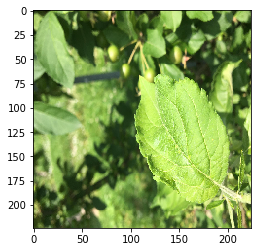

In [4]:
plt.imshow(data_x[15])
print(data_y[15])

[0 0 0 1]


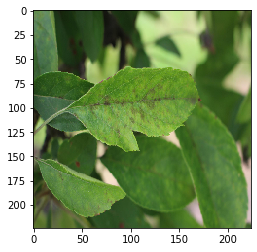

In [5]:
plt.imshow(data_x[0])
print(data_y[0])

[0 0 1 0]


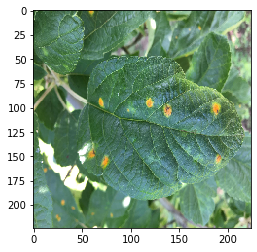

In [6]:
plt.imshow(data_x[5])
print(data_y[5])

## Augmentation

In [7]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [38]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

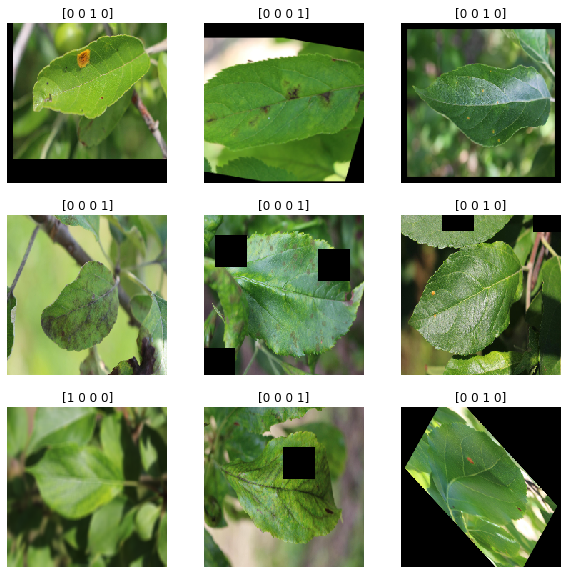

In [39]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [40]:
base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

In [41]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 6148      
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


In [48]:
np.argmax(y_train,axis=1)

array([3, 0, 0, ..., 2, 2, 2])

In [49]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [ ]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
23/22 [==============================] - 23s 1s/step - loss: 24.3656 - accuracy: 0.2914 - val_loss: 10.4642 - val_accuracy: 0.3041 - lr: 5.0000e-04
Epoch 2/100
23/22 [==============================] - 20s 856ms/step - loss: 7.7021 - accuracy: 0.3050 - val_loss: 7.0299 - val_accuracy: 0.3507 - lr: 5.0000e-04
Epoch 3/100
23/22 [==============================] - ETA: 0s - loss: 6.2673 - accuracy: 0.3043

In [ ]:
# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

In [11]:
model.save('models/InceptionResNetV2.h5')

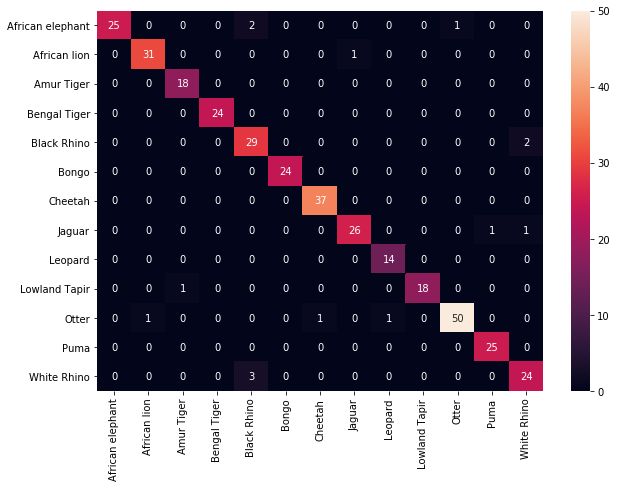

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['African elephant','African lion','Amur Tiger','Bengal Tiger', 'Black Rhino','Bongo' 
          ,'Cheetah','Jaguar','Leopard','Lowland Tapir', 'Otter','Puma','White Rhino']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [17]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("InceptionResNetV2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('InceptionResNetV2.tflite', 'wb') as f:
    f.write(tflite_model)

In [49]:
for i in range(5):
    index = np.random.randint(2390)
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y[index])

    interpreter = tf.lite.Interpreter(model_path="InceptionResNetV2.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (299,299)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result2039====
[[ 8.329775    9.2781515  -6.616677    1.3610272   0.228928   -5.3604536
  -3.934691    7.8704886   3.407471   -0.09927348 23.132019    4.494958
  -2.0975418 ]]
10
====TFLite result====
[[ 3.5870628   7.8632803  -3.3958733   0.24929924 -0.28832027 -4.517113
  -0.25846645  6.780815    1.5215472  -0.3445454  16.460524    3.9094965
  -2.9181762 ]]
10
====TF Model result66====
[[-2.659813    3.195975   -4.700597    6.8095584   1.7405972  24.425665
   8.734784   -2.8948507   4.4056334  -0.69356227 -7.1187973   9.461396
   1.2145058 ]]
5
====TFLite result====
[[-2.3883789  -1.1383936  -1.655189    6.088379    0.05215206  8.3238
   5.5213513   2.9551673   3.5795772  -1.6559896  -4.111552    7.5958066
   3.0846462 ]]
5
====TF Model result1239====
[[ 9.700891   -0.8781422  -8.340824   -9.830415   37.523376    0.5788122
  -2.898225    2.4215918   7.4806495  12.682601    0.17151162 -3.4455094
  12.575679  ]]
4
====TFLite result====
[[ 4.923331   -0.21947886 -1.8439144 